In [3]:
import os as os
import pickle as pkl
from shapely.geometry import Polygon, Point
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

#### importing plot of usa that is made up of hundreds of grids defined as points

243


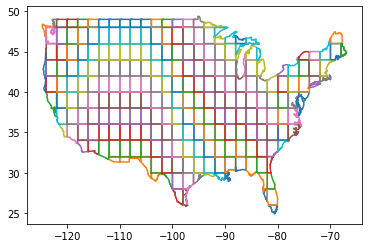

In [4]:
usaPolyGrid = pkl.load(open("util/usaPolyGrid.pkl",'rb'))
for i in usaPolyGrid.values():
    plt.plot(i[:,1],i[:,0])
print(len(usaPolyGrid))

### Example of grid edge of USA

243


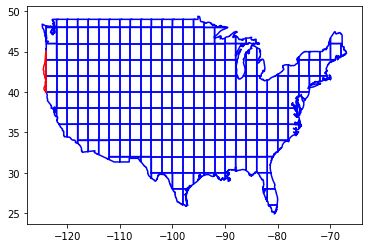

In [5]:
count = 0
for i in usaPolyGrid.values():
    if count != 0:
        plt.plot(i[:,1],i[:,0], c='blue')
    count += 1
print(len(usaPolyGrid))

poly = Polygon(np.flip(usaPolyGrid[0]))
x,y = poly.exterior.xy
plt.plot(x,y, c='red')
plt.show()

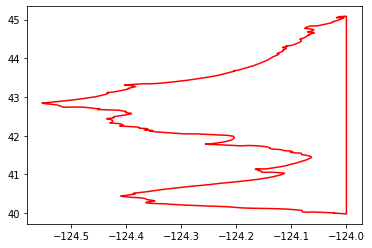

In [6]:
poly = Polygon(np.flip(usaPolyGrid[0]))
x,y = poly.exterior.xy
plt.plot(x,y, c='red')
plt.show()

### Example of grid in middle of USA

243


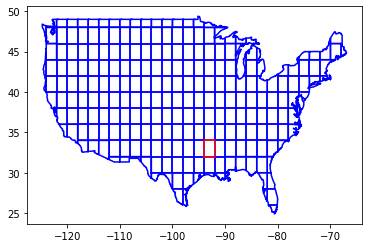

In [7]:
count = 0
for i in usaPolyGrid.values():
    if count != 150:
        plt.plot(i[:,1],i[:,0], c='blue')
    count += 1
print(len(usaPolyGrid))

poly = Polygon(np.flip(usaPolyGrid[150]))
x,y = poly.exterior.xy
plt.plot(x,y, c='red')
plt.show()

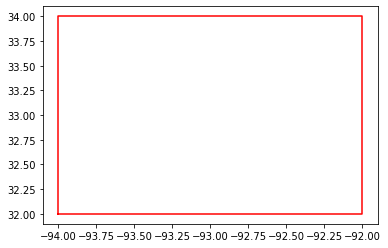

In [8]:
poly = Polygon(np.flip(usaPolyGrid[150]))
x,y = poly.exterior.xy
plt.plot(x,y, c='red')
plt.show()

# Data scraping

In [12]:
import requests
import shutil
import pickle

def Random_Points_in_Polygon(polygon, number):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < number:
        pnt = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points.append(pnt)
    return points

def replace_point(points, location, polygon):
    while True:
        minx, miny, maxx, maxy = polygon.bounds
        pnt = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points[points.index(location)] = pnt
            return points

def visualize_points(polygon, points):
    # Plot the polygon
    xp,yp = polygon.exterior.xy
    plt.plot(xp,yp)

    # Plot the list of points
    xs = [point.x for point in points]
    ys = [point.y for point in points]
    plt.scatter(xs, ys,color="red")
    plt.show()

key = 'Key'
url = 'https://maps.googleapis.com/maps/api/streetview?size=1000x1000&location={},{}&fov={}&heading={}&radius=10000&pitch=10&key={}'
meta_url = 'https://maps.googleapis.com/maps/api/streetview/metadata?size=1000x1000&location={},{}&fov={}&heading={}&radius=10000&pitch=10&key={}'
def save_image(image, dir, location, header):
    location_address = str(location.y) + ","+ str(location.x)
    with open(dir + "/" + str(header) + "_" + str(location_address) + ".jpg", "wb") as f:
        shutil.copyfileobj(image.raw, f)
    del image

def abort(tile_list, list_all):
    pickle.dump(list_all,open("location_progress.pkl","wb"))
    pickle.dump(tile_list, open("tile_progress.pkl", "wb"))

def get_image(location):
    check = True
    for header in [0,90,180]:
        latitude = Point(location).y
        longitude = Point(location).x
        format_url = url.format(str(latitude), str(longitude), 100, header, key)
        meta_format_url = meta_url.format(str(latitude), str(longitude), 100, header, key)
        r = requests.get(format_url, stream=True)
        meta_r = requests.get(meta_format_url, stream=True)
        meta_json = meta_r.json()
        if not r.ok or not meta_r.ok or not meta_json["status"] == 'OK':
            break
        if check:
            if meta_json["pano_id"] in all_locations :
                break
            check = False
            command = 'mkdir -p Data/' + str(tile) + "/" + str(latitude) + "," + str(longitude)
            perm_command = 'chmod -R 777 ' + 'Data/' + str(tile) + "/" + str(latitude) + "," + str(longitude)
            if not os.path.exists(command):
                p = os.system('echo %s|sudo -S %s' % (sudoPassword, command))
                p = os.system('echo %s|sudo -S %s' % (sudoPassword, perm_command))
            all_locations.update({meta_json["pano_id"]: meta_json})

        save_image(r, 'Data/' + str(tile) + "/" + str(latitude) + "," + str(longitude), location, header)
    return check



#### Can only take 115 pictures per 1 of 243 grid of us because of Google street view api allows around 28,0000 api requests per free key.

In [17]:
sudoPassword = 'User Password'
start_tile = 0
if os.path.exists('location_progress.pkl'):
    all_locations = pkl.load(open("location_progress.pkl",'rb'))
else:
    all_locations = {}
if os.path.exists('tile_progress.pkl'):
    tile_locations = pkl.load(open("tile_progress.pkl",'rb'))
    start_tile = max(tile_locations.keys())
else:
    tile_locations = {}
for tile, points in usaPolyGrid.items():
    if tile >= start_tile:
        poly = Polygon(np.flip(points))
        gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[poly])
        rand_points = Random_Points_in_Polygon(poly, 115)
        command = 'mkdir -p Data/' + str(tile)
        if not os.path.exists('Data/' + str(tile)):
            command = 'mkdir -p Data/' + str(tile)
            perm_command = 'sudo chmod -R 777 Data/*'
            p = os.system('echo %s|sudo -S %s' % (sudoPassword, command))
            p = os.system('echo %s|sudo -S %s' % (sudoPassword, perm_command))
        tile_pictures = []
        for location in rand_points:
            while get_image(location):
                index = rand_points.index(location)
                rand_points = replace_point(rand_points, location, poly)
                location = rand_points[index]
        tile_locations.update({tile: rand_points})

abort(tile_locations, all_locations)



In [20]:
print(usaPolyGrid.keys)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/shane/Documents/dev/Geoguessr_example/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-2a090b269780>", line 1, in <module>
    print(usaPolyGrid.keys)
  File "<ipython-input-20-2a090b269780>", line 1, in <module>
    print(usaPolyGrid.keys)
  File "/home/shane/.local/share/JetBrains/Toolbox/apps/DataSpell/ch-0/222.4345.24/plugins/python-ce/helpers/pydev/_pydevd_bundle/pydevd_frame.py", line 747, in trace_dispatch
    self.do_wait_suspend(thread, frame, event, arg)
  File "/home/shane/.local/share/JetBrains/Toolbox/apps/DataSpell/ch-0/222.4345.24/plugins/python-ce/helpers/pydev/_pydevd_bundle/pydevd_frame.py", line 144, in do_wait_suspend
    self._args[0].do_wait_suspend(*args, **kwargs)
  File "/home/shane/.local/share/JetBrains/Toolbox/apps/DataSpell/ch-0/222.4345.24/plugins/python-ce/helpers/pydev/pydevd.py", line 

TypeError: object of type 'NoneType' has no len()